# Profit-efficient treatment assignment for causal inference

In [70]:
import numpy as np

# Data

The data generating process works as follows (story just for reference):
Revenue ($y_i$) depends on some characteristics $X_i$ of the customer i. Customers are given a coupon (treatment $g_i$) with 50% probability . Customer who receive a coupon will spend more or less money (treatment effect $\tau_i$) depending linearly on their characteristics.

$$y_i = X_i ^\top \beta_X + g_i \cdot (\tau_0 + X_i ^\top \beta_{\tau} + \epsilon^{\tau}_i) + \epsilon_i$$

with 

$$\epsilon_i \sim \text{Normal}(mean = 0, std = 0.1)$$

$$g_i \sim \text{Bernoulli}(p= ? )$$
$$\epsilon^{\tau}_i \sim \text{Normal}(mean = 0, std = 0.001)$$

I think there is merit to the assumption that the true reponse model is often more complex than the model behind the heterogeneity of treatment effects. 


In [71]:
from scipy.stats import logistic

class DataGeneratingProcess():
    def __init__(self, n_var, mode="regression", tau_zero=None):
        self.mode = mode
        
        # Linear effects
        self.beta     = np.random.normal(loc=0, scale=0.2, size=n_var)
        # Non-linear effects (optional)
        self.beta_X2  = np.random.normal(loc=0, scale=0.2, size=n_var)
        # Linear effects on treatment effect
        self.beta_tau = np.random.normal(loc=0, scale=0.2, size=n_var)
        # Baseline treatment effect
        self.tau_zero=tau_zero
        if self.tau_zero is None:
            self.tau_zero = np.random.normal(-0.1,0.01)
            
            
    def experiment(self, X, g=None, prop_score=None):
        n_obs=X.shape[0]
        if g is None:
            g = np.zeros(n_obs)
        
        tau = self.tau_zero + np.dot(X,self.beta_tau) + np.random.normal(scale=0.001, size=n_obs)
        
        y = (np.dot(X,self.beta) +
#             np.dot(np.power(X,2),self.beta_X2) +
             g * tau + np.random.normal(scale=0.1, size=n_obs))
        
        if self.mode == "classification":
            #y = np.random.binomial(1, p=logistic.cdf(y))
            y = (logistic.cdf(y)>0.5)*1
                
        return X,y,g,tau, prop_score
        
    

In [72]:
N_OBS = 100000
N_VAR = 10

dgp = DataGeneratingProcess(10, mode="classification")

X = np.random.multivariate_normal(
         np.zeros(N_VAR),
         np.eye(N_VAR)*1,
         N_OBS
         )

In [73]:
experiment = {}
experiment["none_treated"] = dgp.experiment(X)
experiment["all_treated"] = dgp.experiment(X, np.ones(N_OBS))
experiment["balanced"] = dgp.experiment(X, g=np.random.binomial(1, p=0.5, size = N_OBS))

We typically want to be conservative and try new treatment only on a small subset of the population.

In [74]:
experiment["imbalanced"] = dgp.experiment(X, g=np.random.binomial(1, p=0.2, size = N_OBS))

Many companies have a human or model-based decision system in place to assign treatment a subgroup of observations. For example, in the churn setting, a model would assign marketing treatment to customer who are likely to churn (i.e. p_churn above a threshold). 

We can keep existing infrastructure that has proven effective, but add a random component by assigning treatment non-deterministically. In practice, we could assign the marketing treatment relative to the probability of churn.

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

response_model = LogisticRegression(C=100, solver='lbfgs')

response_model.fit(X=X, y=experiment["none_treated"][1])
treat_prob = response_model.predict_proba(X)[:,1]
print(roc_auc_score(experiment["none_treated"][1], treat_prob))

0.9871185059951937


In [76]:
treat_prob = treat_prob.clip(0.1,0.9)
experiment['individual'] = dgp.experiment(X, g=np.random.binomial(1, p=treat_prob))

## Experiment Evaluation

And what are the ratios of people treated?

In [77]:
for name, setting in experiment.items():
    print(name, setting[2].mean())

none_treated 0.0
all_treated 1.0
balanced 0.49721
imbalanced 0.19882
individual 0.50229


What's the churn rate per treatment schedule? (Lower is better)

TODO: Churn rate should be 10%

In [78]:
for name, setting in experiment.items():
    print(name, setting[1].mean())

none_treated 0.50295
all_treated 0.46736
balanced 0.48583
imbalanced 0.49562
individual 0.409


What's our total cost for each experiment? The cost is linked to the churn rate in each experiment and the cost of our targeting. Let's assume a churner has a constant CLV of 100, marketing treatment costs 10. 

In [92]:
print("Cost, lower is better\n")
for name, setting in experiment.items():
    print(name, (setting[1]*100 + setting[2]*10).sum())

Cost, lower is better

none_treated 5029500.0
all_treated 5673600.0
balanced 5355510
imbalanced 5155020
individual 4592290


## ATE estimation under controlled biased experiment

We haved saved money by assigning treatment to likely churners. But our data does not adhere to the assumptions of the balanced randomized trial anymore. Since we know the true propensity scores, we can control for the biased sampling using inverse probability weighting!

TODO: Add ATE formula

In [80]:
def calc_ATE(y,g,prop_score=None):
    if prop_score is None:    
        prop_score = np.ones(len(y))*0.5
    return ((y*g/prop_score).sum() - (y*(1-g)/(1-prop_score)).sum())/len(y)

In [85]:
experiment["all_treated"][1].mean() - experiment["none_treated"][1].mean()

-0.03559000000000001

In [86]:
calc_ATE(experiment["balanced"][1], experiment["balanced"][2])

-0.04146

In [87]:
prop_score = np.ones(X.shape[0]) * 0.2
calc_ATE(experiment["imbalanced"][1], experiment["imbalanced"][2], prop_score)

-0.03615

In [88]:
calc_ATE(experiment["individual"][1], experiment["individual"][2], treat_prob)

-0.037714199971999186

## Repeated experiments

In [48]:
ATE = {"balanced":[],"imbalanced":[],"individual":[]}

experiment = {}
experiment["none_treated"] = dgp.experiment(X)
experiment["all_treated"] = dgp.experiment(X, np.ones(N_OBS))

ATE_true = experiment["all_treated"][1].mean() - experiment["none_treated"][1].mean()

response_model = LogisticRegression(C=100, solver='lbfgs')
response_model.fit(X=X, y=experiment["none_treated"][1])
treat_prob = response_model.predict_proba(X)[:,1]

treat_prob = treat_prob.clip(0.1,0.9)

for _ in range(500):
    experiment["balanced"] = dgp.experiment(X, g=np.random.binomial(1, p=0.5, size = N_OBS))
    ATE["balanced"].append(calc_ATE(experiment["balanced"][1], experiment["balanced"][2]))
 
    experiment["imbalanced"] = dgp.experiment(X, g=np.random.binomial(1, p=0.2, size = N_OBS))
    prop_score = np.ones(X.shape[0]) * 0.2
    ATE["imbalanced"].append(calc_ATE(experiment["imbalanced"][1], experiment["imbalanced"][2], prop_score))
    

    experiment['individual'] = dgp.experiment(X, g=np.random.binomial(1, p=treat_prob))
    ATE["individual"].append(calc_ATE(experiment["individual"][1], experiment["individual"][2], treat_prob))



In [49]:
print(ATE_true)
{key:np.mean(x) for key,x in ATE.items()}

-0.059380000000000044


{'balanced': -0.058875519999999994,
 'imbalanced': -0.058537075,
 'individual': -0.058568877064268283}

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


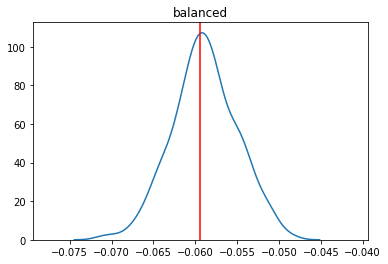

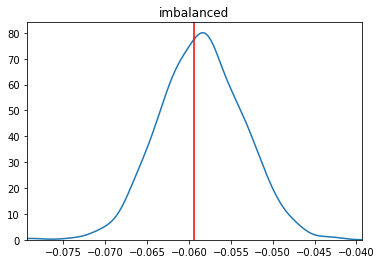

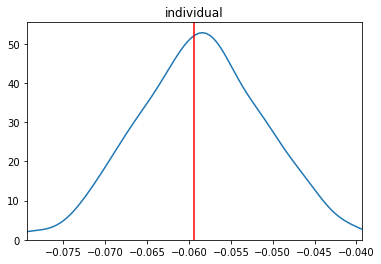

In [51]:
for key,ate in ATE.items():
    sns.kdeplot(ate)
    plt.xlim(ATE_true-0.02,ATE_true+0.02)
    plt.axvline(x=ATE_true, color="red")
    plt.title(key)
    plt.show()

## Individual treatment effect estimation

For evaluation in the simulation context, I assume that the treatment effects are known and calculate the accuracy on the model in estimating the treatment effects on a holdout validation set. In practice, the true treatment effects are unknown, of course, so holdout evaluation is an open question.

In [307]:
#from sklearn.linear_model import SGDClassifier
#from sklearn.metrics import mean_absolute_error
#model = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, penalty="none")

#modlib = {key:model.fit(X,y, sample_weight=prop) for key, (X,y,w,g,prop) in experiment.items()}
#MAE = {key:mean_absolute_error(mo) for key, model in modlib.items()}

## Old Code below

In [267]:
np.mean(y), np.std(y)

NameError: name 'y' is not defined

ATE summary statistics. These should be stable to confirm that the info-noise ratio in the data is not too high.

In [228]:
# True ATE and standard deviation of individual treatment effects
print(f"Baseline treatment effect (True ATE):{dgp.tau_zero}")
print(f"Sample treatment effect (ITE Mean, ITE Std.): {np.mean(tau), np.std(tau)}")
print(f"Empirical ATE: {np.mean(y[g==1]) - np.mean(y[g==0])}")

Baseline treatment effect (True ATE):-0.11581118586682598
Sample treatment effect (ITE Mean, ITE Std.): (0.10564810264497133, 0.273717858076607)
Empirical ATE: nan


/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
print(f"Baseline MSE for treatment effect prediction on validation data:\
      {np.mean((tau_val - (np.mean(y[g==1]) - np.mean(y[g==0])))**2)}")

Baseline MSE for treatment effect prediction on validation data:      0.12391618297544664


In [12]:
data = ExperimentData(X,y,g)

## Setup

In [13]:
pred = OrderedDict()
pred_val = OrderedDict()

In [14]:
pred["ATE"] = (y[g==1].mean()-y[g==0].mean()) * np.ones([X.shape[0]])
pred_val["ATE"] = y[g==1].mean()-y[g==0].mean() * np.ones([X_val.shape[0]])

## Summary

In [57]:
tau_zero

0.10380047919005067

In [58]:
y[g==1].mean() - y[g==0].mean()

0.10548894867393199

In [59]:
{key:x.mean() for key,x in pred.items()}

{'ATE': 0.105488948673932,
 'tnet': 0.11168234,
 'batch_cnn': 0.111191034,
 'res_cnn': 0.11248301}

Absolute error against true (unknown) treatment effects (Lower is better)

In [60]:
{key:np.abs(x-tau_val).mean() for key,x in pred_val.items()}

{'ATE': 0.2798043699350534,
 'tnet': 0.4054825585269063,
 'batch_cnn': 0.462945421836178,
 'res_cnn': 0.4068920708844783}

Ranking metrics for continuous variables ([-1;1], higher is better)

In [61]:
# Weighted number of rank mistakes
from scipy.stats import spearmanr, kendalltau
{key:kendalltau(tau_val, x, nan_policy='propagate')[0] for key,x in pred_val.items()}

{'ATE': nan,
 'tnet': 0.8595502200880353,
 'batch_cnn': 0.487946218487395,
 'res_cnn': 0.8574994797919169}

In [62]:
{key:spearmanr(tau_val, x, nan_policy='propagate')[0] for key,x in pred_val.items()}

/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


{'ATE': nan,
 'tnet': 0.9730393887103023,
 'batch_cnn': 0.6763422427427589,
 'res_cnn': 0.9722625258660043}

In [63]:
#from pylift.eval import UpliftEval
#{key:UpliftEval(g_val,y_val,x) for key,x in pred_val.items()}

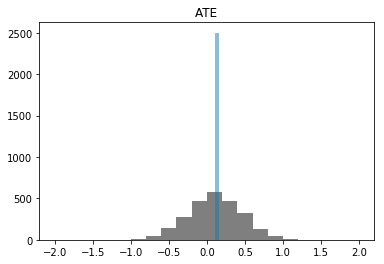

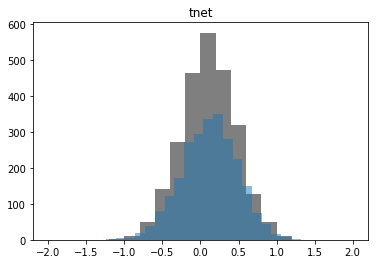

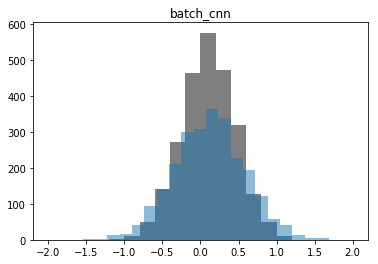

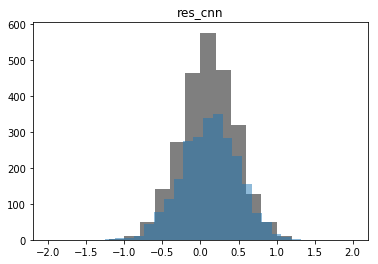

In [70]:
for i,x in pred_val.items():
    plt.hist(tau_val, color='black', alpha=0.5, range=[-2,2], bins=20)
    plt.hist(x, alpha=0.5, bins=20)
    plt.title(i)
    plt.show()
